In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/AirPassengers.csv')

In [3]:
df['Month'] = pd.to_datetime(df['Month'])

In [4]:
df.set_index('Month', inplace=True)

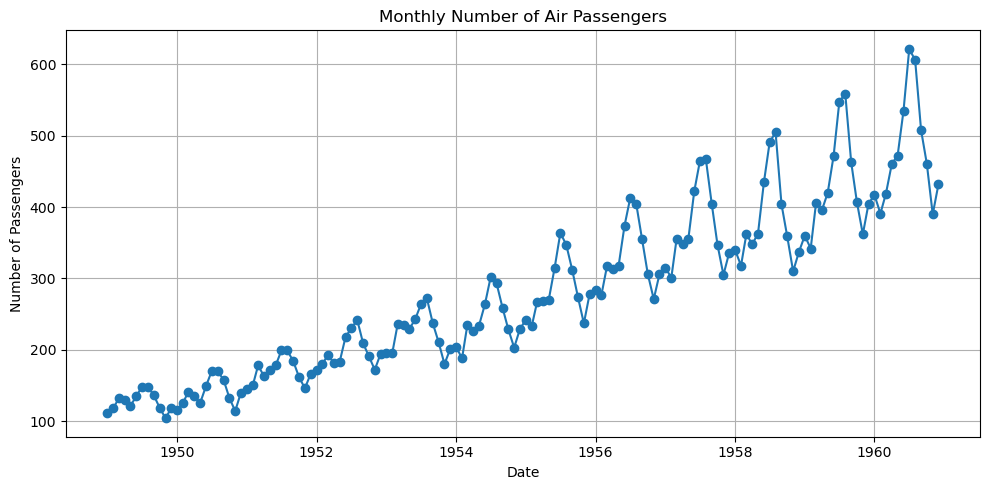

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df['#Passengers'], marker='o')
plt.title('Monthly Number of Air Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.tight_layout()
plt.show() 

In [8]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print('The series is stationary')
    else:
        print('The series is non-stationary')

In [9]:
print('Original Series:')
adf_test(df['#Passengers'])

Original Series:
ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
The series is non-stationary


In [15]:
df['Passengers_Diff'] = df['#Passengers'].diff()
diff_clean = df['Passengers_Diff'].replace([np.inf, -np.inf], np.nan).dropna()
print(diff_clean.head())
print('NaN values in differenced series:', diff_clean.isna().sum())
print('Inf values in differenced series:', np.isinf(diff_clean).sum())
adf_test(diff_clean)

Month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
Name: Passengers_Diff, dtype: float64
NaN values in differenced series: 0
Inf values in differenced series: 0
ADF Statistic: -2.829266824169992
p-value: 0.0542132902838265
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
The series is non-stationary


In [17]:
df['Passengers_Log'] = np.log(df['#Passengers'])
print('\nLog Transformed Series:')
adf_test(df['Passengers_Log'])


Log Transformed Series:
ADF Statistic: -1.7170170891069636
p-value: 0.4223667747703897
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
The series is non-stationary


In [18]:
df['Passengers_Sqrt'] = np.sqrt(df['#Passengers'])
print('\nSquare Root Transformed Series:')
adf_test(df['Passengers_Sqrt'])


Square Root Transformed Series:
ADF Statistic: -0.34585376771568455
p-value: 0.9187543217618355
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
The series is non-stationary


In [40]:
df['Passengers_Log'] = np.log(df['#Passengers'])

# Seasonal differencing (lag 12)
df['Log_Seasonal_Diff'] = df['Passengers_Log'].diff(12)

# First-order differencing
df['Log_Seasonal_First_Diff'] = df['Log_Seasonal_Diff'].diff()

# Drop NaN values for analysis
stationary_series = df['Log_Seasonal_First_Diff'].dropna()

# ADF test for stationarity
print('ADF test for log + seasonal + first difference:')
adf_test(stationary_series)

ADF test for log + seasonal + first difference:
ADF Statistic: -4.443324941831128
p-value: 0.0002485912311383993
Critical Values: {'1%': np.float64(-3.4870216863700767), '5%': np.float64(-2.8863625166643136), '10%': np.float64(-2.580009026141913)}
The series is stationary


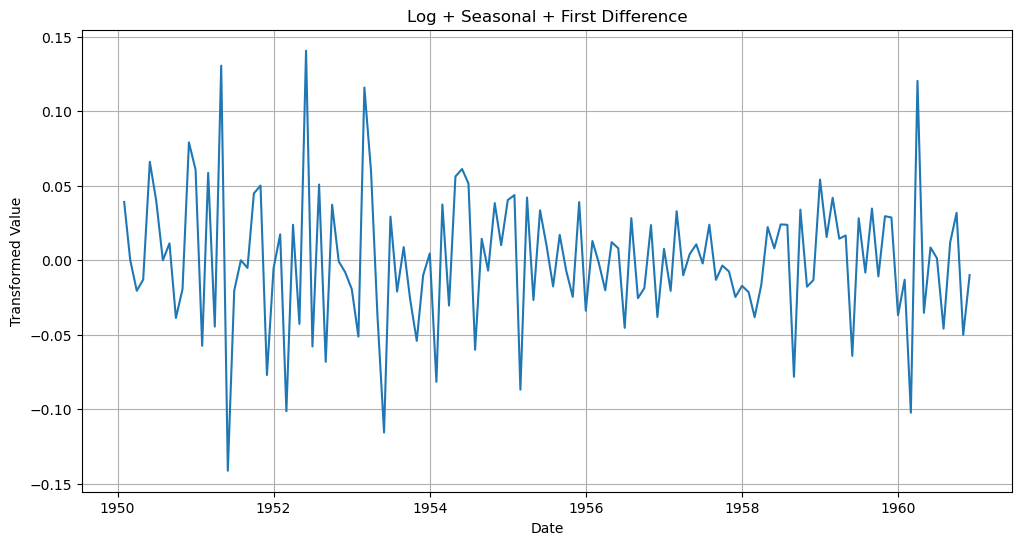

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(stationary_series)
plt.title('Log + Seasonal + First Difference')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.grid(True)
plt.show()

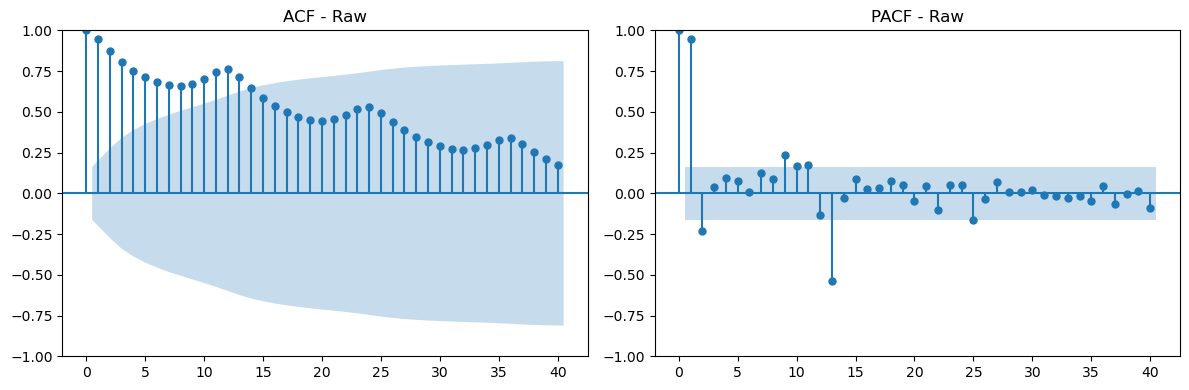

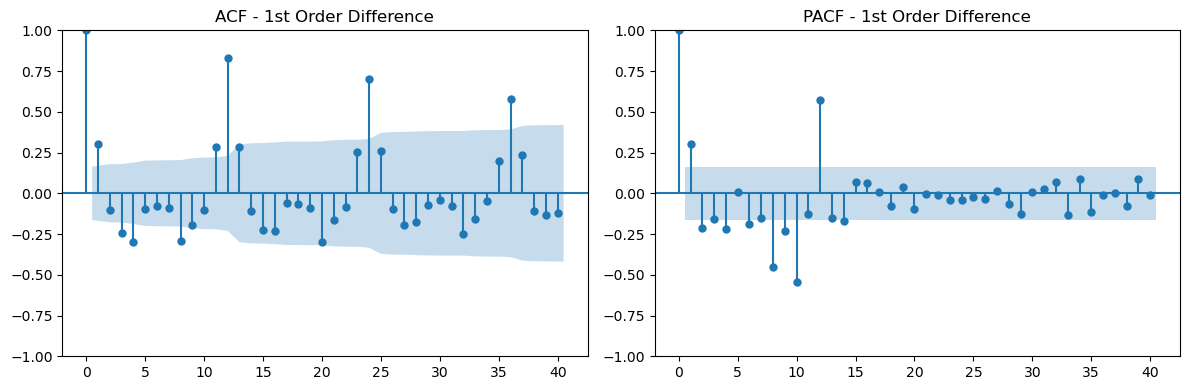

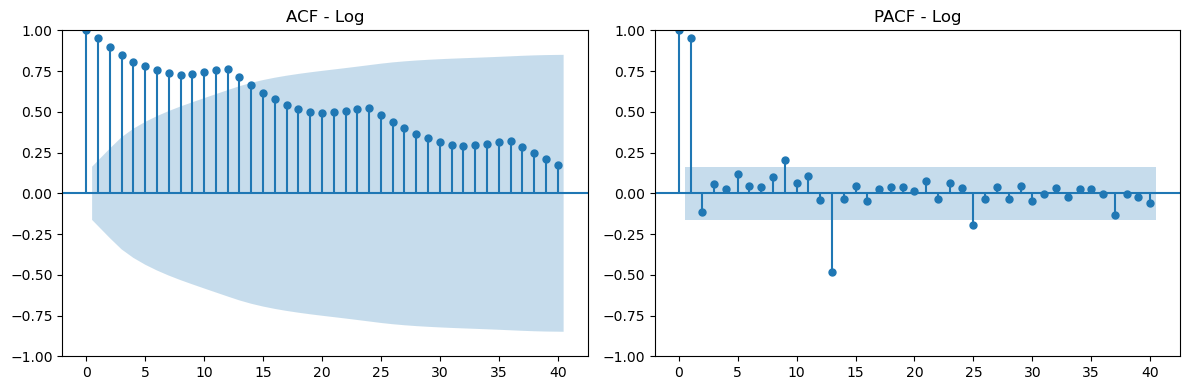

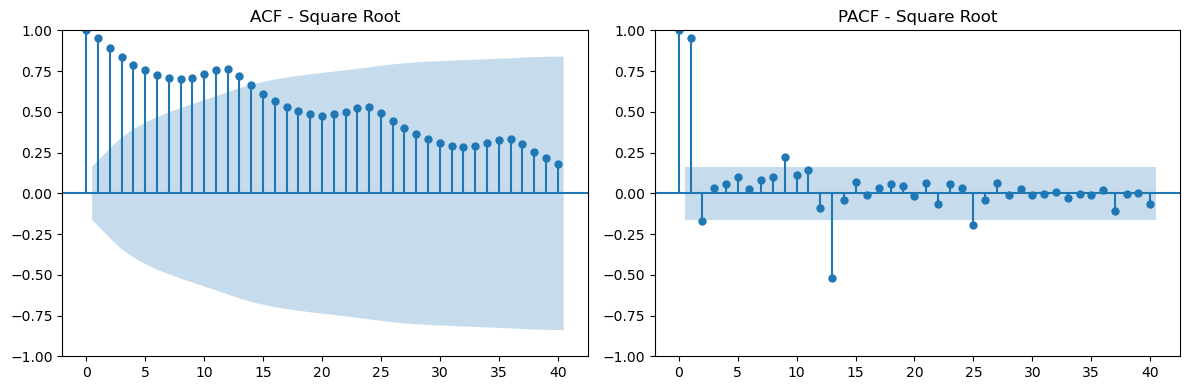

In [42]:
series_dict = {
    'Raw': df['#Passengers'],
    '1st Order Difference': diff_clean,
    'Log': df['Passengers_Log'],
    'Square Root': df['Passengers_Sqrt']
}

for name, series in series_dict.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_acf(series.dropna(), ax=plt.gca(), lags=40)
    plt.title(f'ACF - {name}')
    plt.subplot(1, 2, 2)
    plot_pacf(series.dropna(), ax=plt.gca(), lags=40, method='ywm')
    plt.title(f'PACF - {name}')
    plt.tight_layout()
    plt.show()

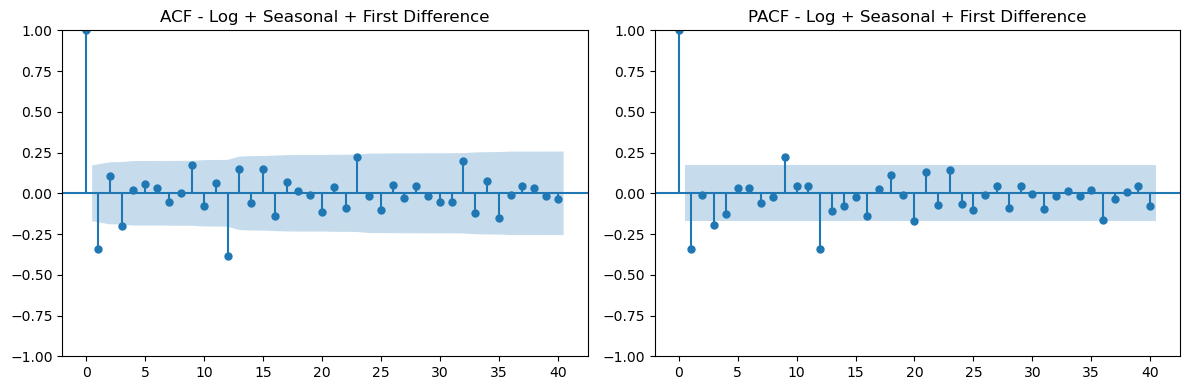

In [44]:
# Assuming stationary_series is your final transformed series
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(stationary_series, ax=plt.gca(), lags=40)
plt.title('ACF - Log + Seasonal + First Difference')

plt.subplot(1, 2, 2)
plot_pacf(stationary_series, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF - Log + Seasonal + First Difference')

plt.tight_layout()
plt.show()

In [50]:
df['Passengers_Log'] = np.log(df['#Passengers'])
df['Log_Seasonal_Diff'] = df['Passengers_Log'].diff(12)
df['Log_Seasonal_First_Diff'] = df['Log_Seasonal_Diff'].diff()
stationary_series = df['Log_Seasonal_First_Diff'].dropna()

In [52]:
split_date = '1958-01-01'
train_stationary = stationary_series[:split_date]
test_stationary = stationary_series[split_date:]

In [54]:
order = (1, 0, 1)  # Example: ARIMA(1,0,1) on already differenced data
model = ARIMA(train_stationary, order=order)
model_fit = model.fit()

print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Log_Seasonal_First_Diff   No. Observations:                   96
Model:                      ARIMA(1, 0, 1)   Log Likelihood                 163.155
Date:                     Sat, 14 Jun 2025   AIC                           -318.311
Time:                             17:14:44   BIC                           -308.053
Sample:                         02-01-1950   HQIC                          -314.164
                              - 01-01-1958                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.192      0.848      -0.005       0.006
ar.L1          0.1679      0.207      0.811      0.418      -0.238       0.574
ma.L1       

C:\Users\Acer\miniconda3\envs\TSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\miniconda3\envs\TSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\miniconda3\envs\TSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [55]:
n_test = len(test_stationary)
forecast_stationary = model_fit.forecast(steps=n_test)

In [56]:
last_log_values = df['Passengers_Log'].iloc[-n_test-12:-n_test].values

In [57]:
log_reconstructed = []
for i in range(n_test):
    if i < 12:
        value = forecast_stationary.iloc[i] + last_log_values[i]
    else:
        value = forecast_stationary.iloc[i] + log_reconstructed[i-12]
    log_reconstructed.append(value)
log_reconstructed = np.array(log_reconstructed)

In [59]:
forecast_original = np.exp(log_reconstructed)

In [60]:
test_actual = df['#Passengers'].loc[split_date:]

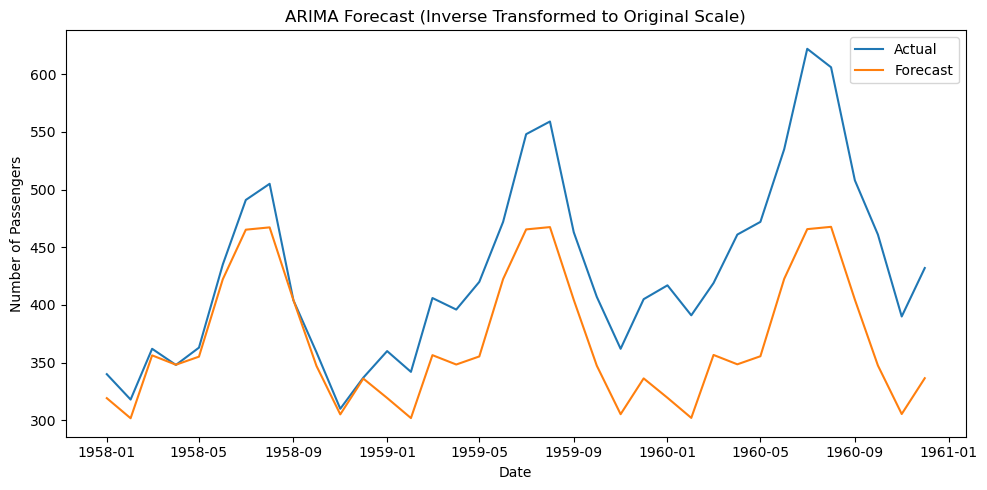

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(test_actual.index, test_actual.values, label='Actual')
plt.plot(test_actual.index, forecast_original, label='Forecast')
plt.title('ARIMA Forecast (Inverse Transformed to Original Scale)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
mape = np.mean(np.abs((test_actual.values - forecast_original) / test_actual.values)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 13.00%


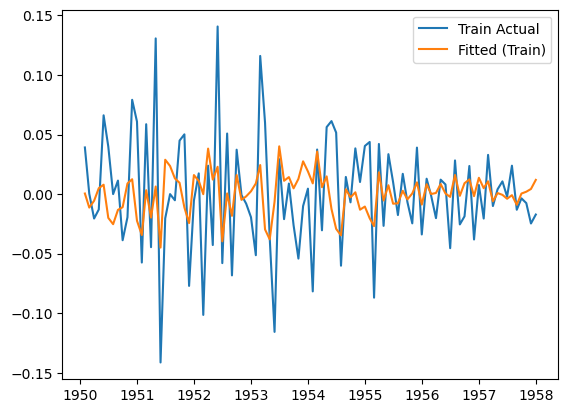

In [63]:
plt.plot(train_stationary.index, train_stationary, label='Train Actual')
plt.plot(train_stationary.index, model_fit.fittedvalues, label='Fitted (Train)')
plt.legend()
plt.show()

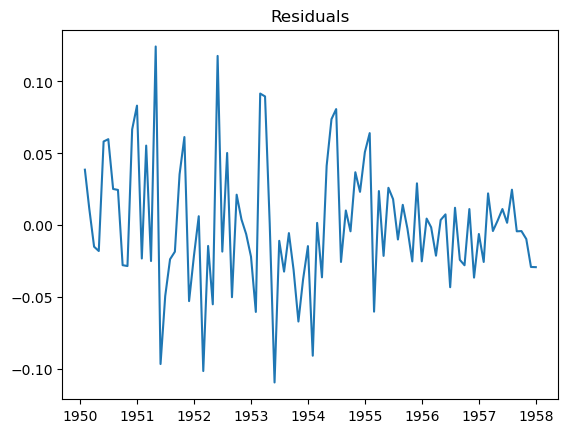

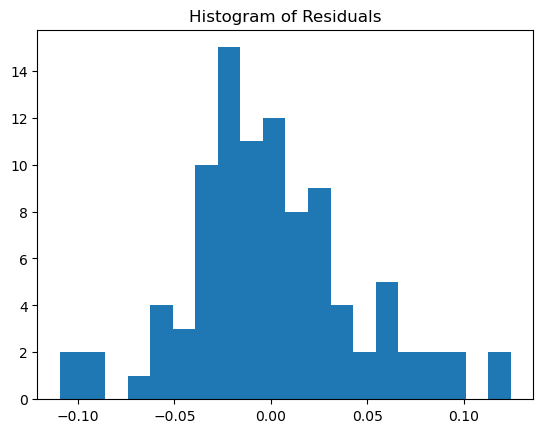

In [64]:
  residuals = train_stationary - model_fit.fittedvalues
  plt.plot(residuals)
  plt.title('Residuals')
  plt.show()
  plt.hist(residuals.dropna(), bins=20)
  plt.title('Histogram of Residuals')
  plt.show()

In [71]:
start = test_actual.index[0]
end = test_actual.index[-1]

forecast_stationary = model_fit.predict(start=start, end=end)

In [72]:
n_test = len(test_actual)

last_log_values = df['Passengers_Log'].iloc[-n_test-12:-n_test].values

log_reconstructed = []
for i in range(n_test):
    if i < 12:
        value = forecast_stationary.iloc[i] + last_log_values[i]
    else:
        value = forecast_stationary.iloc[i] + log_reconstructed[i-12]
    log_reconstructed.append(value)
log_reconstructed = np.array(log_reconstructed)

In [73]:
forecast_original = np.exp(log_reconstructed)

In [75]:
mape = np.mean(np.abs((test_actual.values - forecast_original) / test_actual.values)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 12.92%


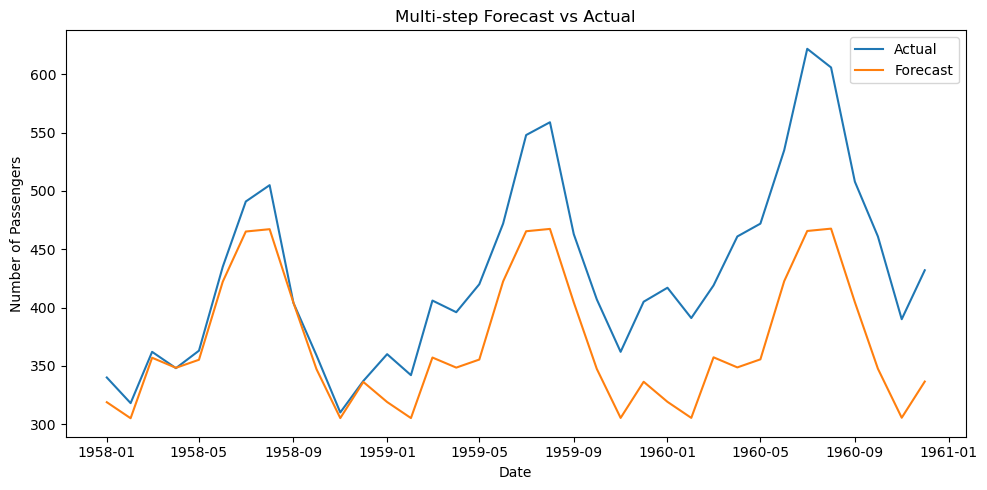

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(test_actual.index, test_actual.values, label='Actual')
plt.plot(test_actual.index, forecast_original, label='Forecast')
plt.title('Multi-step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
#use for modeling
def inverse_transform(transformed_series, original_log_series, transformation_type, seasonal_period=12):
    if transformation_type == 'diff':
        return original_log_series.iloc[0] + transformed_series.cumsum()
    elif transformation_type == 'log':
        return np.exp(transformed_series)
    elif transformation_type == 'sqrt':
        return transformed_series ** 2
    elif transformation_type == 'log_seasonal_first_diff':
        n = len(transformed_series)
        last_log_values = original_log_series.iloc[-n-seasonal_period:-n].values
        log_reconstructed = []
        for i in range(n):
            if i < seasonal_period:
                value = transformed_series.iloc[i] + last_log_values[i]
            else:
                value = transformed_series.iloc[i] + log_reconstructed[i-seasonal_period]
            log_reconstructed.append(value)
        return np.exp(np.array(log_reconstructed))
    else:
        return transformed_series

In [78]:
def expanding_window_cv(df, order, start_date, steps=1, transformation_type='log_seasonal_first_diff', seasonal_period=12):
    preds = []
    actuals = []
    dates = []
    idx_start = df.index.get_loc(start_date)
    n = len(df)
    for i in range(idx_start, n - steps + 1):
        # Prepare training and test sets in stationary space
        train = df['Log_Seasonal_First_Diff'].iloc[:i]
        test = df['#Passengers'].iloc[i:i+steps]
        # Fit ARIMA on stationary series
        if len(train) < order[0] + order[2]:
            continue
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        # Forecast in stationary space
        forecast_stationary = model_fit.forecast(steps=steps)
        # Inverse transform: reconstruct original scale
        forecast_original = inverse_transform(
            forecast_stationary,
            original_log_series=df['Passengers_Log'].iloc[:i],
            transformation_type=transformation_type,
            seasonal_period=seasonal_period
        )
        preds.extend(forecast_original)
        actuals.extend(test.values)
        dates.extend(test.index)
    return np.array(preds), np.array(actuals), dates

One-step MAPE: 12.15%


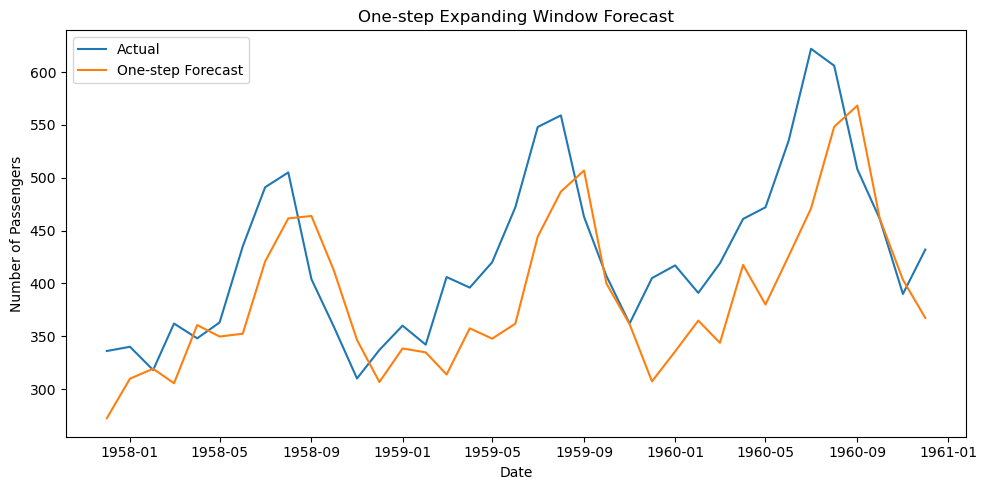

In [82]:
one_step_preds, one_step_actuals, one_step_dates = expanding_window_cv(
    df, order=(1, 0, 1), start_date='1957-12-01', steps=1
)

one_step_mape = np.mean(np.abs((one_step_actuals - one_step_preds) / one_step_actuals)) * 100
print(f'One-step MAPE: {one_step_mape:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(one_step_dates, one_step_actuals, label='Actual')
plt.plot(one_step_dates, one_step_preds, label='One-step Forecast')
plt.title('One-step Expanding Window Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.tight_layout()
plt.show()

Multi-step MAPE: 20.85%


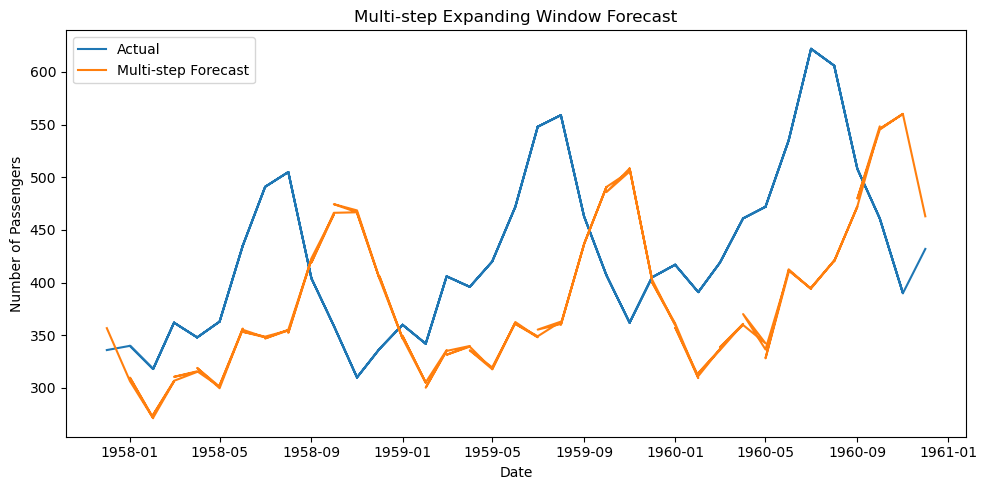

In [83]:
multi_step_preds, multi_step_actuals, multi_step_dates = expanding_window_cv(
    df, order=(1, 0, 1), start_date='1957-12-01', steps=3
)

multi_step_mape = np.mean(np.abs((multi_step_actuals - multi_step_preds) / multi_step_actuals)) * 100
print(f'Multi-step MAPE: {multi_step_mape:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(multi_step_dates, multi_step_actuals, label='Actual')
plt.plot(multi_step_dates, multi_step_preds, label='Multi-step Forecast')
plt.title('Multi-step Expanding Window Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.tight_layout()
plt.show()